# Project 1
# Numerical Methods for the Linear-Advection Equation

Solve the one-dimensional wave equation

$$
\frac{\partial u}{\partial t} + a\frac{\partial u}{\partial x} = 0 
,\quad a = \frac{1}{2}
$$

with

$$
u(x, 0) = \frac{1}{2}(1 + \tanh[250(x - 20)]), \quad 0 \le x \le 40
$$

Choose initially 41 grid point mesh with $\Delta x = 1$ and compute to $t = 10$

## 1.
Solve this problem for all three methods for $\Delta t = 1.0$ and $\Delta t = 0.5$, and compare graphically with the exact stationary solution. Discuss the differences between the various solutions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from latexify import latexify
latexify()

/home/selimb/miniconda/envs/mcgill/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# constants
TMAX = 10
A = 0.5
GRID_LENGTH = 40

In [4]:
# Define the initial signal that is being advected
def signal(x):
    tanh = np.tanh(250.0*(x - 20.0))
    return 0.5*(1.0 + tanh)
# Calculate the exact solution at a given time at given positions
def exact(t, dx, extra_width=0):    
    start = A*t
    end = start + GRID_LENGTH
    left = start - extra_width
    right = end + extra_width
    x = np.arange(left, right + dx, dx)
    x_signal_range = np.logical_and(x >= start, x <= end)
    x_signal_offset = x[x_signal_range][0]
    u_exact_signal = np.empty_like(x)
    u_exact_signal[x_signal_range] = signal(x[x_signal_range] - x_signal_offset)
    u_exact_signal[x < start] = u_exact_signal[x_signal_range][0]
    u_exact_signal[x > end] = u_exact_signal[x_signal_range][-1]
    return x,  u_exact_signal

In [5]:
# Initial Conditions
dx = 0.1
x0 = np.arange(0, GRID_LENGTH + dx, dx, dtype=float)
u0 = signal(x0)

In [6]:
# Schemes: Forward difference in time
def upwind(um, ui, up, dt, dx, u):
    u_new = u.copy()
    u_new[1:-1] = ui - A*(dt/dx)*(ui - um)
    return u_new

def lax_friedrichs(um, ui, up, dt, dx, u):
    u_new = u.copy()
    u_new[1:-1] = 0.5*(up + um) - A*0.5*(dt/dx)*(up - um) 
    return u_new
    
def lax_wendroff(um, ui, up, dt, dx, u):
    u_new = u.copy()
    u_new[1:-1] = (ui 
            - 0.5*(dt/dx)*A*(up - um) 
            + 0.5*(dt/dx*A)**2*(up - 2*ui + um))
    return u_new

def time_step(u, dt, dx, scheme):
    """Generic forward difference time step iteration."""
    u = u.copy()
    ui = u[1:-1]
    um = u[:-2]
    up = u[2:]
    u_new = scheme(um, ui, up, dt, dx, u)
    return u_new

def solve(scheme, dt, dx):
    x = np.arange(0, GRID_LENGTH + dx, dx, dtype=float)
    tsteps = int(TMAX/dt)
    u = np.zeros((tsteps, len(x)))
    u[0] = signal(x)
    t = dt
    for i in range(tsteps - 1):
        t += dt
        u[i + 1] = time_step(u[i], dt, dx, scheme)
    return x, u

In [7]:
def mccormack(dt, dx):
    x = np.arange(0, GRID_LENGTH + dx, dx, dtype=float)
    tsteps = int(TMAX/dt)
    u = np.zeros((tsteps, len(x)))
    u[0] = signal(x)
    for n in range(tsteps - 1):
        u_bar = u[n].copy()
        for i in range(1, len(x) - 1):
            u_bar[i] = u[n, i] - A*(dt/dx)*(u[n, i+1] - u[n, i])
        for i in range(1, len(x) - 1):
            u[n + 1, i] = 0.5*(u[n, i] + u_bar[i] - A*(dt/dx)*(u_bar[i] - u[n, i-1]))
    return x, u

In [8]:
def leap_frog(dt, dx):
    def timestep(u_jm1, u_j):
        u_new = u_j.copy()
        u_new[1:-1] = (
                u_jm1[1:-1] 
                - A*(dt/dx)*(u_j[2:] - u_j[:-2]))
        return u_new
    
    x = np.arange(0, GRID_LENGTH + dx, dx, dtype=float)
    tsteps = int(TMAX/dt)
    u = np.zeros((tsteps, len(x)))
    u[0] = signal(x)
    u[1] = timestep(u[0], u[0])
    for i in range(1, tsteps - 1):
        u[i + 1] = timestep(u[i - 1], u[i])
    return x, u

In [9]:
def plot_exact(ax):
    xexact, uexact = exact(TMAX, 0.01)
    ax.plot(xexact, uexact, 'k-', label='Exact')
def plot_options(ax, title):
    ax.set_title('%s' % title)
    ax.set_xlim(15, 30)
    ax.set_ylim(-1.0, 1.5)
    ax.legend(loc='best', fancybox=True)

Let's overplot the solution for all schemes with the following conditions:
$$
\Delta x = 1\\
A = 0.5\\
\Delta t = 2\\
CFL = A\frac{\Delta t}{\Delta x} = 1
$$

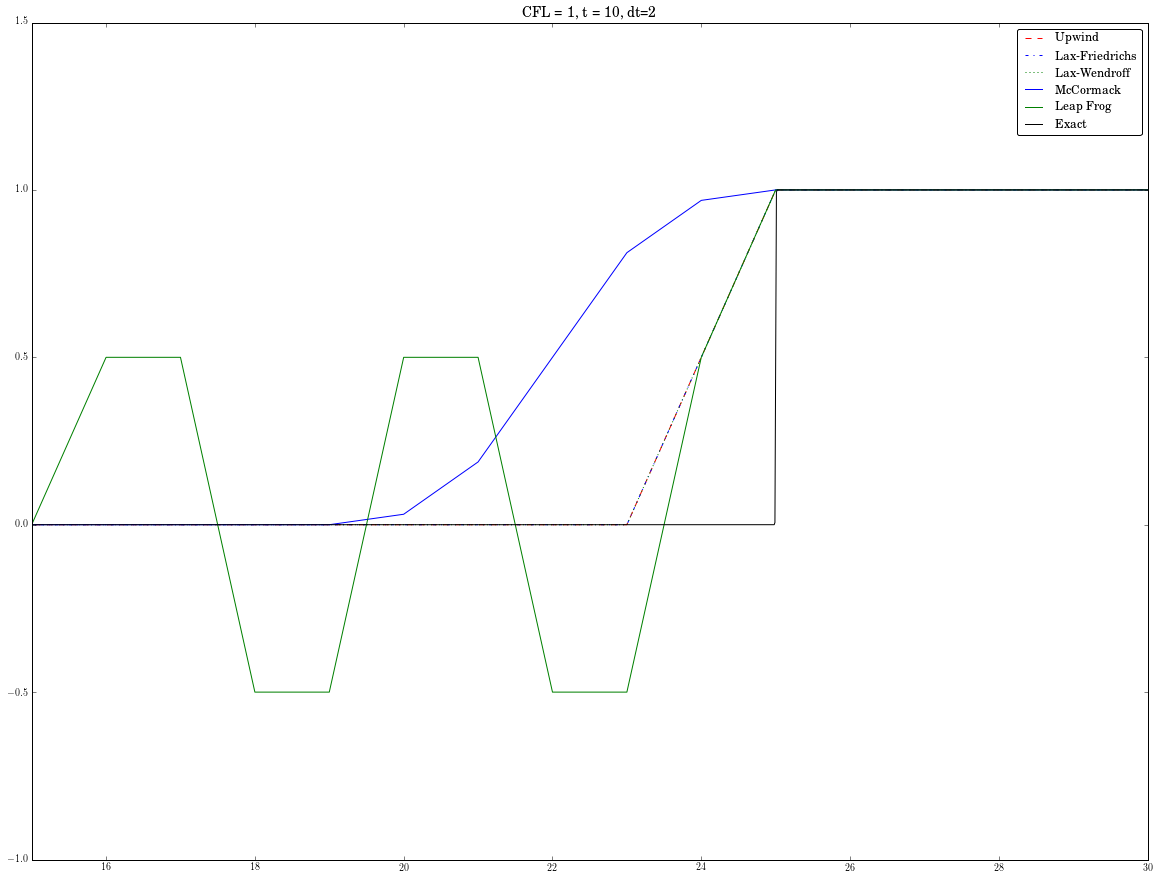

In [10]:
dt = 2
dx = 1
fig, ax = plt.subplots(figsize=(20, 15))
x, u_upwind = solve(upwind, dt, dx) ; ax.plot(x, u_upwind[-1], 'r--', label='Upwind')
_, u_lax = solve(lax_friedrichs, dt, dx) ; ax.plot(x, u_lax[-1], 'b-.', label='Lax-Friedrichs')
_, u_lw = solve(lax_wendroff, dt, dx) ; ax.plot(x, u_lw[-1], 'g:', label='Lax-Wendroff')
_, u_mc = mccormack(dt, dx) ; ax.plot(x, u_mc[-1], '-', label='McCormack')
x, u_lf = leap_frog(dt, dx) ; ax.plot(x, u_lf[-1], '-', label='Leap Frog')
plot_exact(ax)
plot_options(ax, 'CFL = 1, t = 10, dt=2')
plt.show()
fig.savefig('project1latex/highdt.pdf')

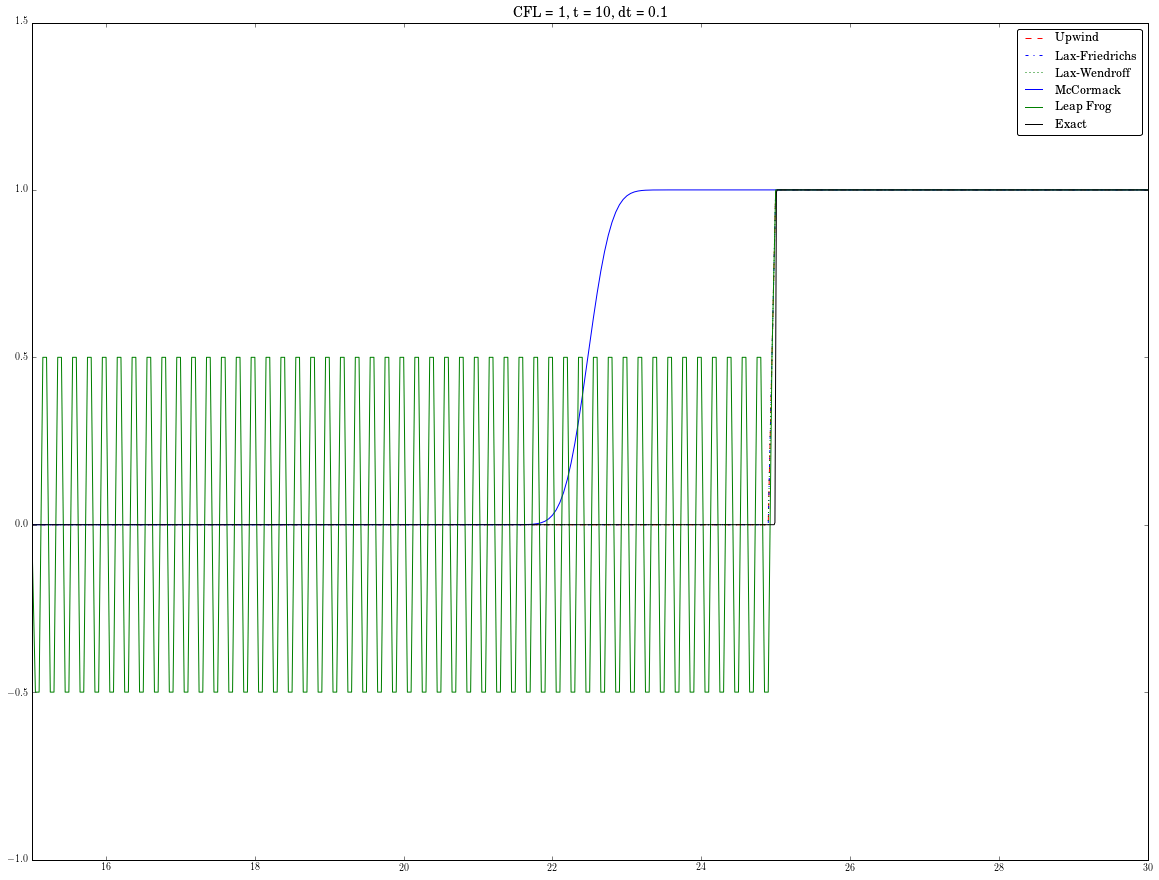

In [11]:
CFL = 1
dt = 0.1
dx = A*dt/CFL
fig, ax = plt.subplots(figsize=(20, 15))
x, u_upwind = solve(upwind, dt, dx) ; ax.plot(x, u_upwind[-1], 'r--', label='Upwind')
_, u_lax = solve(lax_friedrichs, dt, dx) ; ax.plot(x, u_lax[-1], 'b-.', label='Lax-Friedrichs')
_, u_lw = solve(lax_wendroff, dt, dx) ; ax.plot(x, u_lw[-1], 'g:', label='Lax-Wendroff')
_, u_mc = mccormack(dt, dx) ; ax.plot(x, u_mc[-1], '-', label='McCormack')
x, u_lf = leap_frog(dt, dx) ; ax.plot(x, u_lf[-1], '-', label='Leap Frog')
plot_exact(ax)
plot_options(ax, 'CFL = 1, t = 10, dt = 0.1')
plt.show()
fig.savefig('project1latex/lowdt.pdf')

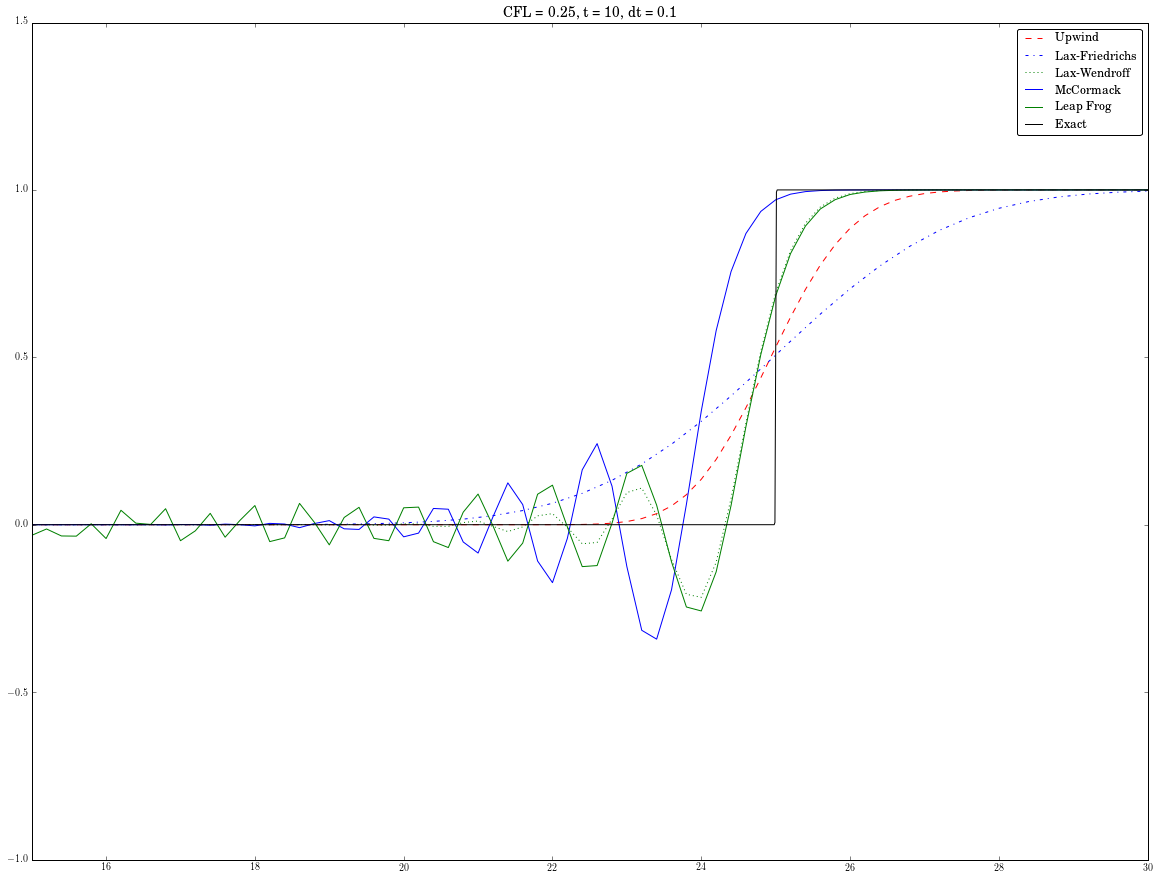

In [12]:
CFL = 0.25
dt = 0.1
dx = A*dt/CFL
fig, ax = plt.subplots(figsize=(20, 15))
x, u_upwind = solve(upwind, dt, dx) ; ax.plot(x, u_upwind[-1], 'r--', label='Upwind')
_, u_lax = solve(lax_friedrichs, dt, dx) ; ax.plot(x, u_lax[-1], 'b-.', label='Lax-Friedrichs')
_, u_lw = solve(lax_wendroff, dt, dx) ; ax.plot(x, u_lw[-1], 'g:', label='Lax-Wendroff')
_, u_mc = mccormack(dt, dx) ; ax.plot(x, u_mc[-1], '-', label='McCormack')
x, u_lf = leap_frog(dt, dx) ; ax.plot(x, u_lf[-1], '-', label='Leap Frog')
plot_exact(ax)
plot_options(ax, 'CFL = 0.25, t = 10, dt = 0.1')
plt.show()
fig.savefig('project1latex/cfl_025.pdf')